In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.stats.multitest import multipletests
from scipy.cluster.hierarchy import linkage, leaves_list

In [2]:
# PARAMETERS
run_id="group_loops.09.19.ldcts"

In [3]:
# Parameters
run_id = "msn.hyper.12.02.ldcts"


In [4]:
selected_traits = {
    "Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_" : "Alzheimers Disease and Dementia", 
    "Nalls.LancetNeurol.2019.Parkinsons_disease_" : "Parkinson's Disease", 
    "PGC.Nature.2014.Schizophrenia_" : "Schizophrenia", 
    "Wray.biorxiv.2018.Major_Depressive_Disorder_" : "Major Depressive Disorder", 
    "Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_" : "ADHD", 
    "Mullins.NatGenet.2021.Bipolar_Disorder_" : "Bipolar Disorder", 
    "Grove.NatGenet.2019.Autism_Spectrum_Disorder_" : "Autism Spectrum Disorder", 
    "Jansen.2019.NatGenet.Insomnia_" : "Insomnia", 
    "PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_" : "Obsessive Compulsive Disorder", 
    "Deary.MolPsychiatry.2017.Tiredness_" : "Tiredness", 
    "IMSGC.Science.2019.Multiple_sclerosis_" : "Multiple Sclerosis", 
    "Luciano.NatGenet.2017.Neuroticism_" : "Neuroticism", 
    "Okbay.Nature.2016.Educational_Attainment_" : "Educational Attainment", 
    "Palmer.MolPsych.2021.problematic_opioid_use_" : "Problematic Opioid Use", 
    "Savage.NatGenet.2018.Intelligence_" : "Intelligence", 
    "vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_" : "Amyotrophic Lateral Sclerosis", 
    "Barban.NatGenet.2016.Age_First_Birth_" : "Age at First Birth", 
    "Chiou.Nature.2021.Type_1_diabetes_" : "Type 1 Diabetes", 
    "Watson.2018.NatGenet.Anorexia_Nervosa_" : "Anorexia Nervosa"
}

In [5]:
ldsc_results=f'/anvil/projects/x-mcb130189/rwang22/bican/ldsc/output/{run_id}'
directory = Path(ldsc_results)
dfs = {}

for file in directory.glob(f'*.cell_type_results.txt'):
    cur = pd.read_csv(file, sep = "\t")
    stripped = file.stem.replace(f'_.cell_type_results', "")
    cur["Trait"] = stripped
    dfs[stripped] = cur

In [6]:
combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df["-log10(pval)"] = -np.log10(combined_df["Coefficient_P_value"])
combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")
combined_df = combined_df[combined_df["Trait"].isin(selected_traits.keys())] # only predetermined selected traits
combined_df.head()

,Name,Coefficient,Coefficient_std_error,Coefficient_P_value,Trait,-log10(pval)
45,STRd_D1_Matrix_MSN,1.643913e-07,1.770529e-07,0.176578,Watson.2018.NatGenet.Anorexia_Nervosa_,0.753065
46,STRd_D2_StrioMat_Hybrid_MSN,1.030072e-07,1.601971e-07,0.260111,Watson.2018.NatGenet.Anorexia_Nervosa_,0.584841
47,STRd_D2_Matrix_MSN,8.719646e-08,1.889425e-07,0.322221,Watson.2018.NatGenet.Anorexia_Nervosa_,0.491846
48,STRd_D1_Striosome_MSN,7.432340e-08,2.590274e-07,0.387082,Watson.2018.NatGenet.Anorexia_Nervosa_,0.412197
49,STRv_D1_MSN,-1.021633e-08,1.095575e-07,0.537148,Watson.2018.NatGenet.Anorexia_Nervosa_,0.269906


In [7]:
# Perform FDR correction using Benjamini-Hochberg procedure
rejected, q_values, _, _ = multipletests(combined_df["Coefficient_P_value"], alpha=0.05, method='fdr_bh')
combined_df["FDR_BH_corrected"] = q_values

In [8]:
# calculate the FDR p value threshold 
# https://www.r-bloggers.com/2023/07/the-benjamini-hochberg-procedure-fdr-and-p-value-adjusted-explained/

def fdr_bh_adj(df):
    tmp = combined_df.copy()
    tmp["rank"] =  combined_df['Coefficient_P_value'].rank()
    num_tests = len(tmp)
    tmp["adj_pval"] = (num_tests * tmp["Coefficient_P_value"]) / tmp["rank"]

    return tmp


In [9]:
tmp = fdr_bh_adj(combined_df)
# Align indices before comparison
fdr_bh_corrected = combined_df["FDR_BH_corrected"]
adj_pval = tmp["adj_pval"]

print(fdr_bh_corrected.sort_values())

801     0.401619
279     0.401619
243     0.401619
244     0.677954
45      0.816802
          ...   
455     0.999735
454     0.999735
453     0.999735
412     0.999735
1052    0.999735
Name: FDR_BH_corrected, Length: 171, dtype: float64


In [10]:
print(adj_pval.sort_values())

279     0.401619
801     0.586835
244     0.677954
243     0.787337
964     0.816802
          ...   
740     1.139031
49      1.148154
932     1.156125
1036    1.157574
282     1.201965
Name: adj_pval, Length: 171, dtype: float64


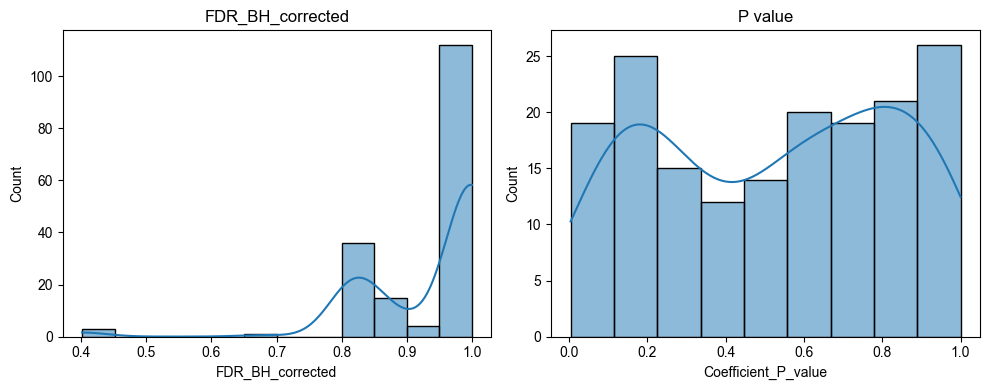

In [11]:
# plot the distribution of p values 
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# First plot
sns.histplot(combined_df["FDR_BH_corrected"], kde=True, ax=axes[0])
axes[0].set_title("FDR_BH_corrected")

# Second plot
sns.histplot(combined_df["Coefficient_P_value"], kde=True, ax=axes[1])
axes[1].set_title("P value")

plt.tight_layout()
plt.show()

In [12]:
modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', 'FDR_BH_corrected'], axis=1)
modified_df = modified_df.pivot(index="Name", columns="Trait", values="-log10(pval)").reset_index()
modified_df = modified_df.set_index("Name")
modified_df.head()

Trait,Barban.NatGenet.2016.Age_First_Birth_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,Chiou.Nature.2021.Type_1_diabetes_,Deary.MolPsychiatry.2017.Tiredness_,Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_,Grove.NatGenet.2019.Autism_Spectrum_Disorder_,IMSGC.Science.2019.Multiple_sclerosis_,Jansen.2019.NatGenet.Insomnia_,Luciano.NatGenet.2017.Neuroticism_,Mullins.NatGenet.2021.Bipolar_Disorder_,Nalls.LancetNeurol.2019.Parkinsons_disease_,Okbay.Nature.2016.Educational_Attainment_,PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_,PGC.Nature.2014.Schizophrenia_,Palmer.MolPsych.2021.problematic_opioid_use_,Savage.NatGenet.2018.Intelligence_,Watson.2018.NatGenet.Anorexia_Nervosa_,Wray.biorxiv.2018.Major_Depressive_Disorder_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_
Name,,,,,,,,,,,,,,,,,,,
STR_D1D2_Hybrid_MSN,0.121938,0.682503,0.000115,0.200719,0.019213,0.405446,0.115076,0.290829,0.148755,0.058835,0.442753,0.006034,0.423255,0.049419,0.105744,0.006044,0.266772,1.045909,0.679734
STRd_D1_Matrix_MSN,1.072736,0.087099,2.152060,0.804623,0.662817,0.179711,0.657287,0.567301,0.895644,0.727959,0.031749,0.945696,0.963270,0.790835,0.353735,0.772820,0.753065,0.935574,0.086560
STRd_D1_Striosome_MSN,0.107438,0.090915,0.022798,1.065852,0.104990,0.039786,0.238733,1.431184,0.925353,0.912426,0.119006,0.248383,0.272364,0.827516,0.123613,0.032508,0.412197,0.645283,0.449626
STRd_D2_Matrix_MSN,2.163450,0.068619,1.583602,0.200795,0.745786,0.259172,0.626118,0.214933,0.213342,0.300034,0.062250,0.600101,1.106135,0.017125,0.261729,0.501919,0.491846,0.247563,0.159562
STRd_D2_StrioMat_Hybrid_MSN,0.121375,0.267976,0.127452,0.172408,0.026150,0.266577,0.310935,0.114458,0.233778,0.050914,1.390344,0.184426,0.061902,0.000593,0.561806,0.013470,0.584841,0.125521,2.336836


In [13]:
fdr_modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', '-log10(pval)'], axis=1)
fdr_modified_df = fdr_modified_df.pivot(index="Name", columns="Trait", values="FDR_BH_corrected").reset_index()
fdr_modified_df = fdr_modified_df.set_index("Name")
fdr_modified_df.head()

Trait,Barban.NatGenet.2016.Age_First_Birth_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,Chiou.Nature.2021.Type_1_diabetes_,Deary.MolPsychiatry.2017.Tiredness_,Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_,Grove.NatGenet.2019.Autism_Spectrum_Disorder_,IMSGC.Science.2019.Multiple_sclerosis_,Jansen.2019.NatGenet.Insomnia_,Luciano.NatGenet.2017.Neuroticism_,Mullins.NatGenet.2021.Bipolar_Disorder_,Nalls.LancetNeurol.2019.Parkinsons_disease_,Okbay.Nature.2016.Educational_Attainment_,PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_,PGC.Nature.2014.Schizophrenia_,Palmer.MolPsych.2021.problematic_opioid_use_,Savage.NatGenet.2018.Intelligence_,Watson.2018.NatGenet.Anorexia_Nervosa_,Wray.biorxiv.2018.Major_Depressive_Disorder_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_
Name,,,,,,,,,,,,,,,,,,,
STR_D1D2_Hybrid_MSN,0.999735,0.851163,0.999735,0.999735,0.999735,0.999735,0.999735,0.999735,0.999735,0.999735,0.979270,0.999735,0.992721,0.999735,0.999735,0.999735,0.999735,0.816802,0.851163
STRd_D1_Matrix_MSN,0.816802,0.999735,0.401619,0.816802,0.855572,0.999735,0.855572,0.875591,0.816802,0.816802,0.999735,0.816802,0.816802,0.816802,0.999735,0.816802,0.816802,0.816802,0.999735
STRd_D1_Striosome_MSN,0.999735,0.999735,0.999735,0.816802,0.999735,0.999735,0.999735,0.816802,0.816802,0.816802,0.999735,0.999735,0.999735,0.816802,0.999735,0.999735,0.999735,0.860004,0.979270
STRd_D2_Matrix_MSN,0.401619,0.999735,0.816802,0.999735,0.816802,0.999735,0.860557,0.999735,0.999735,0.999735,0.999735,0.875591,0.816802,0.999735,0.999735,0.933895,0.933895,0.999735,0.999735
STRd_D2_StrioMat_Hybrid_MSN,0.999735,0.999735,0.999735,0.999735,0.999735,0.999735,0.999735,0.999735,0.999735,0.999735,0.816802,0.999735,0.999735,0.999735,0.875591,0.999735,0.875591,0.999735,0.401619


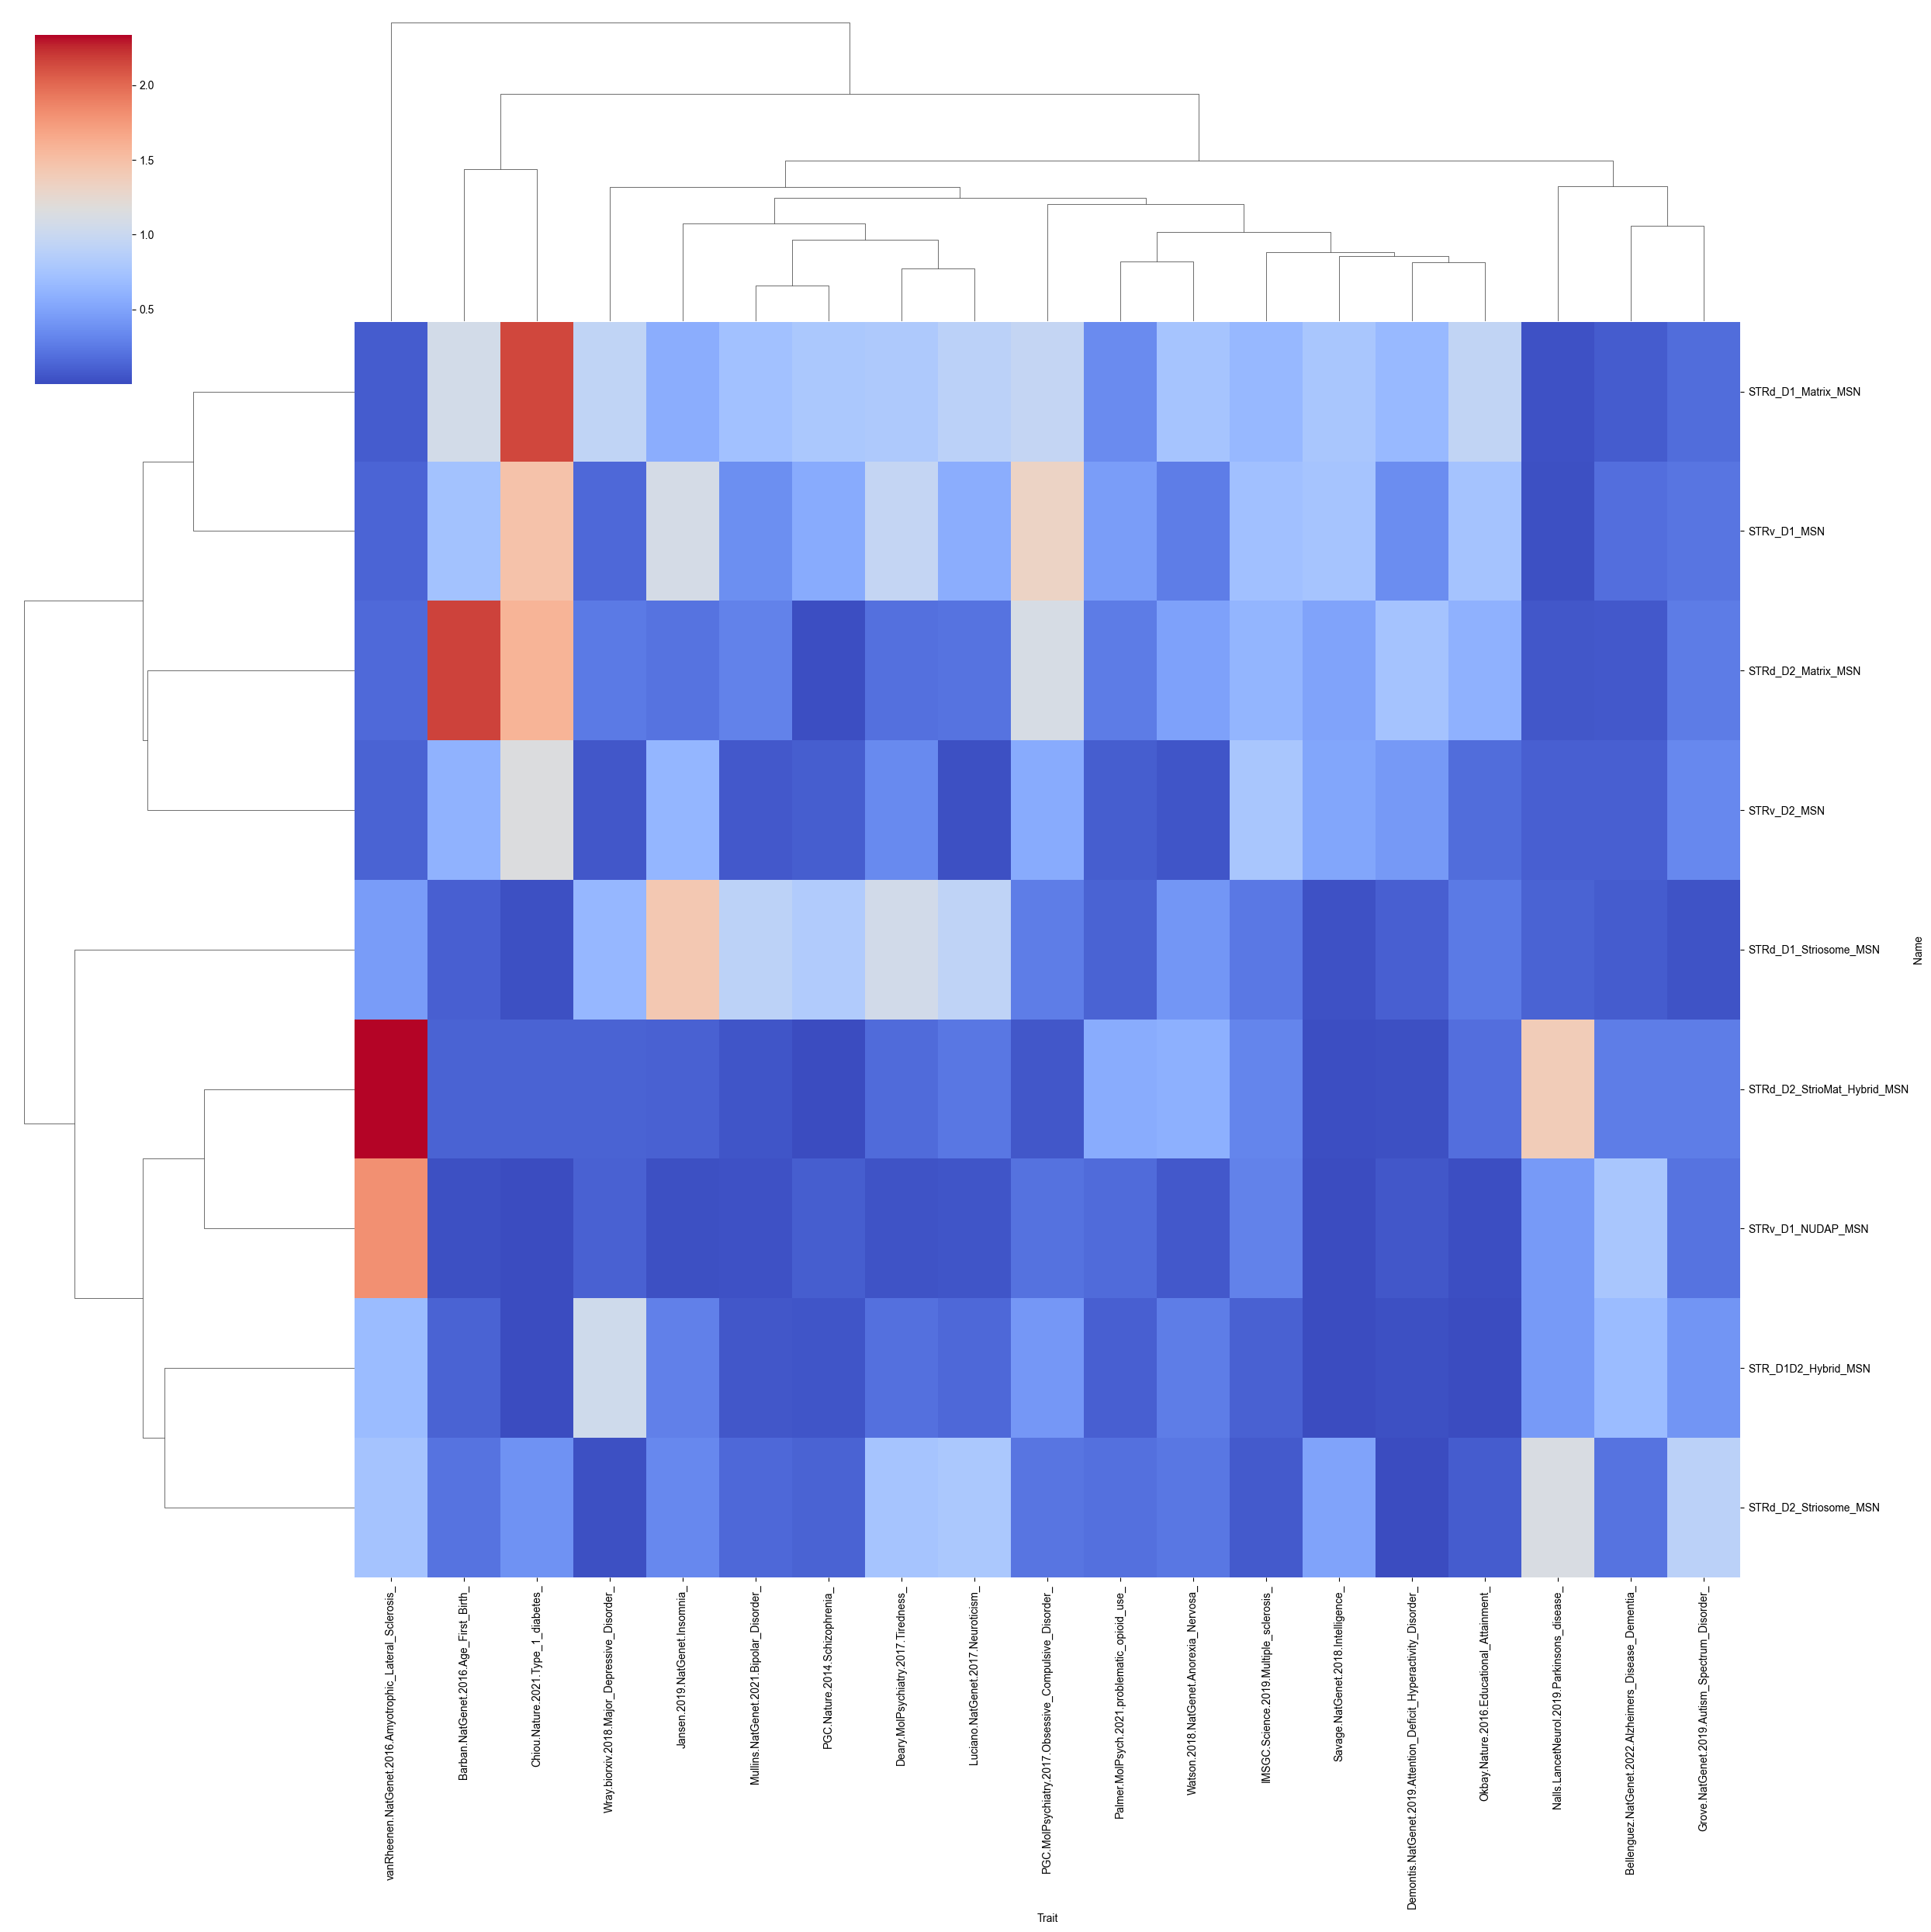

In [14]:
g = sns.clustermap(modified_df, cmap='coolwarm', figsize=(25, 25))

plt.show()
# g.savefig(f'output/{run_id}_filtered.pdf')

In [15]:
def pval_to_star(p):
    if p < 1e-7:
        return '***'
    elif p < 1e-5:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

In [16]:
# Cluster rows
linkage_rows = linkage(modified_df.values, method="average", metric="euclidean")
row_order = leaves_list(linkage_rows)

# Cluster columns
linkage_cols = linkage(modified_df.values.T, method="average", metric="euclidean")
col_order = leaves_list(linkage_cols)

modified_df = modified_df.iloc[row_order, col_order].rename(columns = selected_traits)
fdr_modified_df = fdr_modified_df.iloc[row_order, col_order].rename(columns = selected_traits)

In [17]:
fdr_modified_df = fdr_modified_df.reindex(
    index=modified_df.index,    # same row order as df
    columns=modified_df.columns # same column order as df
)

In [18]:
cols_to_keep = fdr_modified_df.loc[:, (fdr_modified_df < 0.05).any()].columns
cols_to_keep

Index([], dtype='object', name='Trait')

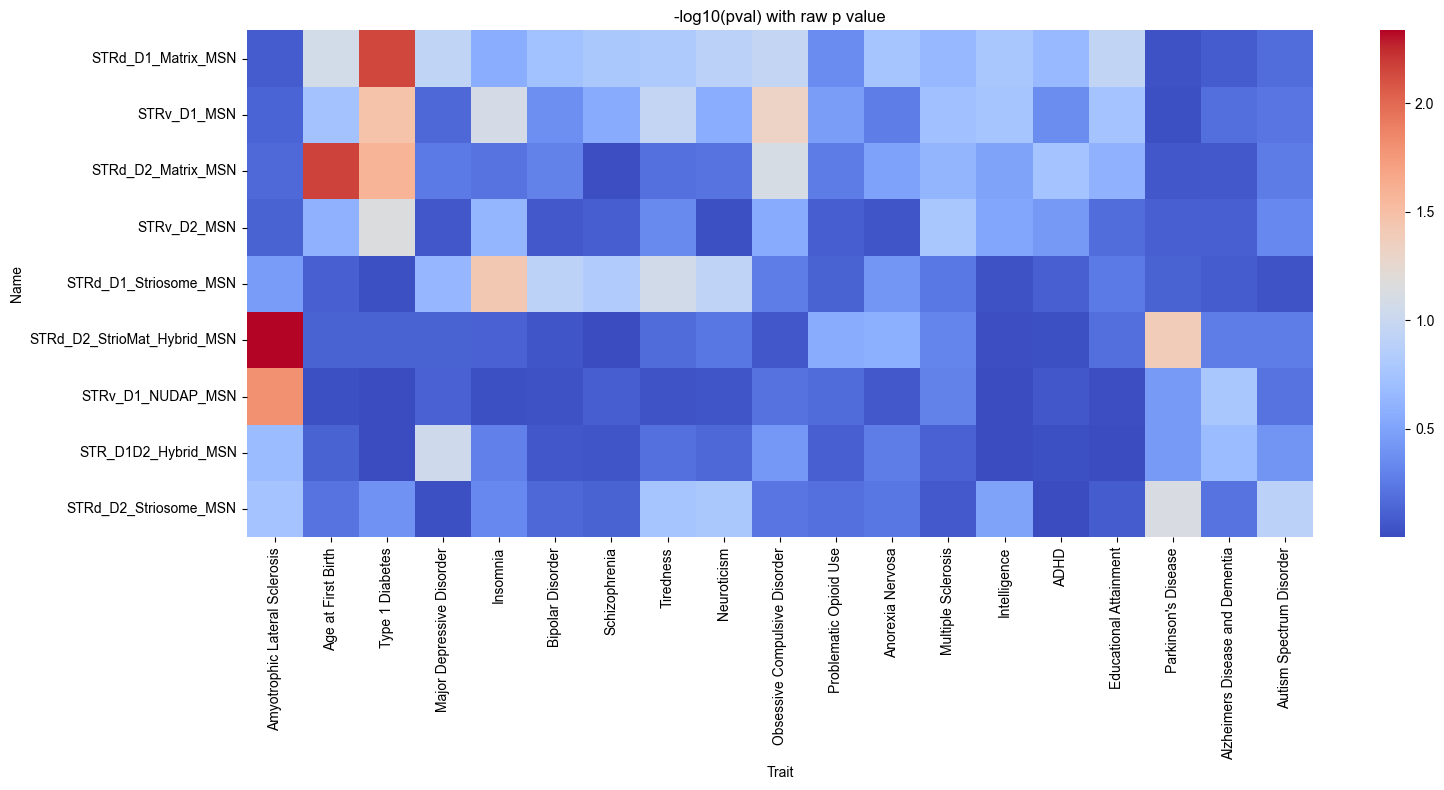

In [19]:
if len(cols_to_keep) > 0:
    stars = fdr_modified_df[cols_to_keep].applymap(pval_to_star)

    # Plot heatmap with annotations
    plt.figure(figsize=(25, 15))
    sns.heatmap(modified_df[cols_to_keep], annot=stars, fmt='', cmap='coolwarm')
    plt.title("-log10(pval) with FDR corrected p value stars")
    plt.tight_layout()
    # plt.savefig(f'output/{run_id}_filtered_FDR_corrected.pdf')
    plt.show()
else:
    # Plot heatmap with annotations
    plt.figure(figsize=(16, 8))
    sns.heatmap(modified_df, fmt='', cmap='coolwarm')
    plt.title("-log10(pval) with raw p value")
    plt.tight_layout()
    # plt.savefig(f'output/{run_id}_filtered_raw_pval.pdf')
    plt.show()

In [20]:
import os
metadata = pd.read_csv(os.path.expanduser("/anvil/projects/x-mcb130189/Wubin/BG/clustering/100kb/annotations.tsv"),sep='\t',index_col=0)
keep_cells=metadata.loc[~ (metadata['Group'].isin(['doublet','Glut','Unk','Low quality cells']))].index.tolist() #,
metadata=metadata.loc[keep_cells]
df_cols = metadata.loc[:,['Subclass','Class','Neighborhood']].drop_duplicates().set_index('Subclass')
df_cols.sort_values(['Neighborhood','Class','Subclass'],inplace=True)
df_cols.head()

,Class,Neighborhood
Subclass,,
F Glut,F M Glut,Glut Sero Dopa
F M Glut,F M Glut,Glut Sero Dopa
M Dopa,M Dopa,Glut Sero Dopa
Astrocyte,Astro-Epen,Nonneuron
Lymphocyte,Immune,Nonneuron


In [21]:
import matplotlib as mpl
mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi']=300

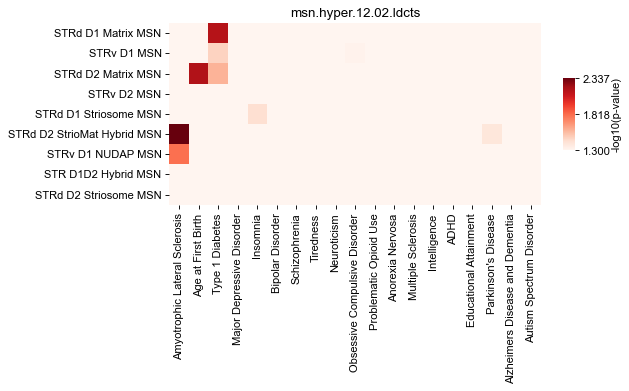

In [27]:
# Plot heatmap with annotations
import os

if len(cols_to_keep) == 0:
    cols_to_keep = modified_df.columns.tolist()

modified_df.index=modified_df.index.to_series().apply(lambda x:x.replace('_',' '))
fdr_modified_df.index=fdr_modified_df.index.to_series().apply(lambda x:x.replace('_',' '))

# row_order=[ct for ct in df_cols.index.tolist() if ct in modified_df.index.tolist()]
vmax=modified_df.loc[:,cols_to_keep].max().max()

fig, ax = plt.subplots(figsize=(8, 5))
ax=sns.heatmap(modified_df.loc[:,cols_to_keep], #annot=fdr_modified_df.loc[row_order,cols_to_keep].applymap(pval_to_star), 
               fmt='', cmap='Reds',cbar_kws={'shrink': 0.4,'fraction':0.1,'aspect':6},
               annot_kws=dict(ha='center',va='center'),vmin=1.3,#vmax=4.85,cbar=False
              ax=ax)
# plt.title("-log10(pval) with FDR corrected p value stars")
ax.set_title(run_id)
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)
cbar = ax.collections[0].colorbar
cbar.set_label("-log10(p-value)", fontsize=10, labelpad=1)
# cbar.set_ticks([1.3,3,4,4.85,vmax])
cbar.set_ticks([1.3,(1.3+vmax)/2,vmax])
plt.tight_layout()
# plt.savefig(f'{run_id}_fig.pdf')
plt.savefig(os.path.expanduser("~/Projects/BG/pseudobulk/DMR/LDSC_plots/MSN.Group.hyper.LDSC.pdf"),transparent=True,bbox_inches='tight',dpi=300)
plt.show()